In [31]:
from pathlib import Path
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.analysis_utils import error_analysis

In [32]:
root_path = Path("../experiment_results")
llms_path_outputs = root_path / "outputs"

In [33]:
llms_path_outputs_fixed = root_path / "fixed_outputs"

In [34]:
fixers = [fixer for fixer in llms_path_outputs_fixed.iterdir() if fixer.is_dir()]

In [35]:
sorted_models = {}
for fixer in fixers:
    pattern = r"(.*)-(\d+|\d+\.\d+)B"
    model = fixer.name
    match = re.search(pattern, model)
    if match:
        model = match[1]
        size = match[2]
        if model not in sorted_models:
            sorted_models[model] = []
        sorted_models[model].append(size)
for model, sizes in sorted_models.items():
    sorted_models[model] = sorted(sizes)

sorted_models

{'Qwen1.5-Chat': ['0.62', '1.84', '14.2', '3.95', '7.72', '72.3'],
 'Phi-2': ['2.78'],
 'Mistral-Instruct-v0.2': ['7.24']}

In [36]:
sorted_models_counts = {}

for model, sizes in sorted_models.items():
    for size in sizes:
        for fixer in fixers:
            if model in fixer.name and size in fixer.name:
                error_analysis(fixer)
                df = pd.read_csv(fixer / "error_categories.csv")
                if model not in sorted_models_counts:
                    sorted_models_counts[model] = {}

                sorted_models_counts[model][str(float(size))] = len(df)

sorted_models_counts

{'Qwen1.5-Chat': {'0.62': 1610,
  '1.84': 1560,
  '14.2': 781,
  '3.95': 1516,
  '7.72': 875,
  '72.3': 740},
 'Phi-2': {'2.78': 1659},
 'Mistral-Instruct-v0.2': {'7.24': 827}}

In [37]:
all_sizes = set()
for model, sizes in sorted_models_counts.items():
    all_sizes.update([float(size) for size in sizes.keys()])

In [38]:
for model, sizes in sorted_models_counts.items():
    for size in all_sizes:
        if str(size) not in sizes:
            sorted_models_counts[model][str(size)] = None

sorted_models_counts = {model: {k: v for k, v in sorted(sizes.items(), key=lambda x: float(x[0]))} for model, sizes in
                        sorted_models_counts.items()}

sorted_models_counts

{'Qwen1.5-Chat': {'0.62': 1610,
  '1.84': 1560,
  '2.78': None,
  '3.95': 1516,
  '7.24': None,
  '7.72': 875,
  '14.2': 781,
  '72.3': 740},
 'Phi-2': {'0.62': None,
  '1.84': None,
  '2.78': 1659,
  '3.95': None,
  '7.24': None,
  '7.72': None,
  '14.2': None,
  '72.3': None},
 'Mistral-Instruct-v0.2': {'0.62': None,
  '1.84': None,
  '2.78': None,
  '3.95': None,
  '7.24': 827,
  '7.72': None,
  '14.2': None,
  '72.3': None}}

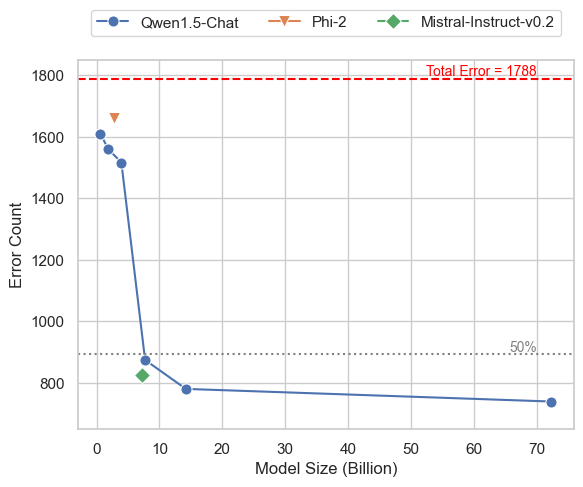

In [39]:
sns.set_theme(style="whitegrid")

markers = {
    "Qwen1.5-Chat": "o",
    "Llama-2-Chat": "s",
    "Mistral-Instruct-v0.2": "D",
    "Mixtral-Instruct-v0.1": "P",
    "CodeLlama-Instruct": "X",
    "Phi-2": "v",
}

for model, sizes in sorted_models_counts.items():
    marker = markers[model]
    df = pd.DataFrame([(float(k), v) for k, v in sizes.items()], columns=["Size", "Error Count"])
    plot = sns.lineplot(data=df, x="Size", y="Error Count", marker=marker, label=model, markersize=8)
    # Annotate each point with model size
    # for x, y in zip(df["Size"], df["Error Count"]):
    #     plot.text(x, y + 3, f"{x:.1f}B", color="black", ha="center", va="bottom", fontsize=10, rotation=90)

# plot.set_title("Error Count of Models")
plot.set_xlabel("Model Size (Billion)")
plot.set_ylim(650, 1850)

# Position the model names at the end of the largest size of the model that is not None at the end of the line
for line in plot.get_lines():
    x, y = line.get_data()
    model = line.get_label()
    y_max = 0
    for i, (x, y) in enumerate(zip(x, y)):
        if y is not None:
            y_max = y
        # For each point, annotate the model size
        # plot.text(x, y - 10, f"{x}B", color=line.get_color(), ha="center", va="center", fontsize=8)

    # plot.text(x + 2, y_max + 7, model, color=line.get_color(), ha="left", va="center", fontsize=10, bbox=dict(facecolor=line.get_color(), alpha=0.1))

# plot.get_legend().remove()
plt.legend(ncol=3, loc='center', bbox_to_anchor=(0.5, 1.1))
plot.axhline(1788, color="red", linestyle="--")
plot.axhline(1788 / 2, color="gray", linestyle=":")
plot.text(70, 1788 + 22, "Total Error = 1788", color="red", ha="right", va="center", fontsize=10)
plot.text(70, 1788 / 2 + 22, "50%", color="gray", ha="right", va="center", fontsize=10)

# # Position the associated values below each data point
# for line in plot.get_lines():
#     x, y = line.get_data()
#     for i, (x, y) in enumerate(zip(x, y)):
#         plot.text(x, y - 3, f"{y:.0f}", color=line.get_color(), ha="center", va="top")

plt.show()